In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
# plt.rcParams['lines.linewidth'] = 1.5
# plt.rcParams['font.size'] = 9
# plt.rcParams["figure.figsize"] = (6.4, 4.8)
plt.rcParams["axes.grid"] = True
plt.rcParams["grid.linestyle"] = "dotted"
plt.rcParams["errorbar.capsize"] = 2
plt.rcParams["savefig.dpi"] = 200
plt.rcParams["savefig.pad_inches"] = 0.01
# plt.rcParams["savefig.savefig.format"] = "svg"

import pint
from uncertainties import ufloat
from uncertainties import unumpy
ureg = pint.UnitRegistry()

/var/folders/b0/r7cwq3l97dz61k8mlk7tswlc0000gn/T/ipykernel_8936/74310850.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
M = ufloat(28.97, 0.01) * (ureg.g / ureg.mol)
R = 8.314_462_618_153_24 * (ureg.J / ureg.mol / ureg.K)

In [3]:
def get_dP(N):
    return 9.8067 * N * 0.2 * 0.991

1. Подготовьте установку к работе:

    а. ознакомьтесь с устройством и характеристиками приборов (газового счетчика и спиртового микроманометра); проведите их предварительную настройку и регулировку согласно техническому описанию установки;
    
    б. ознакомьтесь измерительными шкалами приборов, запишите рабочий диапазон и цену деления; предварительно оцените инструментальные погрешности (по паспортам приборов и/или по цене деления их шкал).

In [4]:
eps_N = 0.5

2. Проведите предварительный запуск установки и убедитесь в ее работоспособности.

    а. Подсоедините манометр к двум соседним выводам на конце одной из трубок (рекомендуется начать с трубки диаметром $d \approx 4 мм$). Убедитесь, что все отверстия, кроме одного — выходного — плотно завинчены пробками.

    б. Убедитесь, что кран К, соединяющий компрессор с установкой, закрыт. Включите компрессор. Переведите рычажок микроманометра в рабочее положение (+).

    в. Медленно приоткрывая кран К и непрерывно контролируя показания микроманометра, создайте небольшой поток воздуха через трубку.

    Не допускайте резких движений крана К и при изменении его положения всегда контролируйте показания микроманометра. При больших перепадах давления спирт может попасть в соединительные трубки, что выведет манометр из строя. При приближении спиртового столбика к максимуму шкалы следует немедленно перекрыть подачу воздуха краном К. **Любые изменения в схеме подключения должны производиться после перевода манометра в положение (0).**

    г. Наблюдайте за показаниями приборов в зависимости от интенсивности потока через трубку. Убедитесь, что при неизменном положении крана К показания манометра стабильны, а стрелка расходомера вращается равномерно.

3. Измерьте параметры окружающей среды: температуру, влажность воздуха и атмосферное давление. В ходе дальнейшей работы следите за этими показаниями и при необходимости фиксируйте их изменения.

   Запишите диаметры трубок (указаны на установке). Зарисуйте схему расположения измерительных отверстий на трубках с указанием расстояний между ними.

In [5]:
T = ufloat(26.1 + 273.15, 0.1) * ureg.K
P = ufloat(976.1, 0.1) * ureg.hPa
rho = (P * M) / (R * T)

In [6]:
d1 = ufloat(3.95, 0.05) * ureg.mm
l1 = ufloat(50, 1) * ureg.cm

d2 = ufloat(3.95, 0.05) * ureg.mm
l2 = ufloat(90, 1) * ureg.cm

d3 = ufloat(5.3, 0.05) * ureg.mm
l3 = ufloat(40, 1) * ureg.cm

# column_data_ufloat = [[d1, l1], [d2, l2], [d3, l3]]
# df_table = pd.DataFrame(columns=[fr'$d=({d.m:L}) \ мм, l=({l.m:L}) \ см$' for d, l in column_data_ufloat])
df_table = pd.DataFrame(columns=[1, 2, 3])

In [7]:
df_table.columns[0]

1

4. Проведите предварительные расчёты:

    а. Рассчитайте значение расхода $Q_{кр}$, при котором число Рейнольдса трубке станет равным критическому $Re_{кр} \approx 10^3$. Для предварительной оценки примите вязкость воздуха равной $\eta_{возд} \approx 2 \cdot 10^{−5} \ Па·с$, плотность воздуха определите по уравнению идеального газа. В качестве характерной скорости потока используйте её среднее значение $\bar{u} = \frac{Q}{\pi R^2}$.

    б. По формуле Пуазейля рассчитайте соответствующий перепад давления выбранном вами участке $\Delta P_{кр}$. Выразите значение $\Delta P_{кр}$ в делениях шкалы микроманометра.

    в. Оцените длину $l_{уст}$, на которой течение можно считать установившимся при $Re \approx Re_{кр}$. Проверьте, можно ли считать установившимся течение на участке, выбранном для проведения измерений.

In [8]:
Re_cr = 1e3
eta_cr = 2e-5 * (ureg.pascal * ureg.second)

In [9]:
def get_Q_cr(d):
    r = d / 2
    u = (Re_cr * eta_cr) / (r * rho)
    Q_cr = u * np.pi * r ** 2
    return Q_cr.to(ureg.ml / ureg.s)

print(get_Q_cr(d1))
print(get_Q_cr(d2))
print(get_Q_cr(d3))

109.2+/-1.4 milliliter / second
109.2+/-1.4 milliliter / second
146.5+/-1.4 milliliter / second


In [10]:
def get_dP_cr(d, l):
    Q_cr = get_Q_cr(d)
    r = d / 2
    dP_cr = (Q_cr * 8 * l * eta_cr) / (np.pi * r ** 4)
    return dP_cr.to(ureg.Pa)

print(get_dP_cr(d1, l1))
print(get_dP_cr(d2, l2))
print(get_dP_cr(d3, l3))

183+/-8 pascal
329+/-13 pascal
60.5+/-2.3 pascal


In [11]:
def get_l_cr(d):
    return 0.2 * (d/2) * Re_cr

print(get_l_cr(d1))
print(get_l_cr(d2))
print(get_l_cr(d3))

395+/-5 millimeter
395+/-5 millimeter
530+/-5 millimeter


5. Меняя расход воздуха краном К и наблюдая за столбиком спирта в микроманометре, визуально определите границу перехода $\Delta P_{кр}$ от ламинарного течения к турбулентному (турбулентный режим характеризуется заметными пульсациями давления во времени). Сравните полученное экспериментально $\Delta P_{кр}$ с оценкой, проведенной в п. 4.

In [12]:
df_table.loc["$\Delta P_{кр}^{виз}$, $Па$"] = get_dP(np.array([65, 100, 36]))
df_table

,1,2,3
"$\Delta P_{кр}^{виз}$, $Па$",126.339716,194.368794,69.972766


6. Подберите параметры измерения расхода газа $Q = \Delta V / \Delta t$, так чтобы его
относительная погрешность составила не более $\varepsilon = 1%$.

    а. Оцените погрешность измерения объёма $\sigma_V$ расходомером (по паспорту
    прибора и/или по цене деления шкалы). Исходя из этого определите минимальный объём проходящего через счётчик газа $V_{min}$, который следует использовать при измерениях расхода.

    б. Оцените погрешность измерения времени $\sigma_t$ и определите минимальный промежуток времени $t_{min}$, в течение которого следует измерять расход. При измерениях с секундомером основную погрешность вносит время реакции человека, которое можно измерить экспериментально. Для этого проведите серию из 7–9 измерений времени прохождения через счётчик объёма газа $V_{min}$ при некотором постоянном расходе и в качестве оценки для случайной погрешности измерения времени используйте среднеквадратичное отклонение результатов.

7. Измерьте зависимости перепада давления $\Delta P$ на выбранном участке трубки от расхода газа $Q$.

    а. Постепенно увеличивая расход, проведите измерения так, чтобы на ламинарный режим течения приходилось 7–9 экспериментальных точек. Примечание: на трубках большого диаметра чувствительности манометра может быть недостаточно для измерений на ламинарном участке с приемлемой точностью — в таком случае рекомендуется увеличить длину участка $l$.

    б. Получите также 7–9 экспериментальных точек в турбулентном режиме, меняя давления от граничного $\Delta P_{кр}$ до максимально возможного на данной трубке. При приближении показаний к максимуму шкалы следует уменьшить чувствительность манометра (увеличить угол наклона).

In [13]:
x_name = '$\Delta P$, $Па$'
y_name = '$Q$, $мл/с$'

In [14]:
def get_df_processed(n):
    df_processed = pd.read_excel('main.xlsx', sheet_name=f'Лист{n}')
    df_processed[x_name] = get_dP(df_processed["$N$"])
    df_processed[y_name] = 1000 / df_processed['$\Delta t$, $c$']
    return df_processed

for i in range(1, 7):
    df = get_df_processed(i)
    df.to_latex(buf=f"tables/table{i}.tex", index=False, float_format="%.1f")
df

,"$\Delta t$, $c$",$N$,"$\Delta P$, $Па$","$Q$, $мл/с$"
0,6.3,53,103.015461,158.730159
1,5.4,75,145.776595,185.185185
2,4.6,102,198.256170,217.391304
3,3.8,142,276.003687,263.157895
4,3.6,166,322.652198,277.777778


11. По результатам измерений п. 7 постройте графики зависимостей расхода от перепада давления $Q(\Delta P)$. Проанализируйте полученные результаты.

    а. Для каждой трубки по графику определите границу перехода от ламинарного участка к турбулентному.

    б. Убедитесь в том, что зависимость $Q(\Delta P)$ на ламинарном участке соответствует является линейной.

    в. Пользуясь формулой Пуазейля, по угловым коэффициентам линейных участков определите вязкость воздуха $\eta$.

    г. Рассчитайте критическое число Рейнольдса $Re_{кр}$. Сравните результат с полученным по наблюдению за колебаниями столбика манометра в п. 5.

    д. Оцените погрешности результатов. Убедитесь, что значение вязкости
    не зависит от диаметра трубки в пределах погрешности. Сравните значение коэффициента вязкости с табличным (с учётом параметров окружающей среды).

In [15]:
def p11(d, l, i, through_zero=True):
    df1 = get_df_processed(2 * i - 1)
    df2 = get_df_processed(2 * i)

    x_data1_ufloat = [get_dP(ufloat(i, eps_N)) for i in df1['$N$']]
    x_data1 = unumpy.nominal_values(x_data1_ufloat)
    x_err1 = unumpy.std_devs(x_data1_ufloat)
    y_data1_ufloat = [1000 / ufloat(i, 0.2) for i in df1['$\Delta t$, $c$']]
    y_data1 = unumpy.nominal_values(y_data1_ufloat)
    y_err1 = unumpy.std_devs(y_data1_ufloat)

    x_data2_ufloat = [get_dP(ufloat(i, eps_N)) for i in df2['$N$']]
    x_data2 = unumpy.nominal_values(x_data2_ufloat)
    x_err2 = unumpy.std_devs(x_data2_ufloat)
    y_data2_ufloat = [1000 / ufloat(i, 0.2) for i in df2['$\Delta t$, $c$']]
    y_data2 = unumpy.nominal_values(y_data2_ufloat)
    y_err2 = unumpy.std_devs(y_data2_ufloat)

    plt.errorbar(
        x_data1,
        y_data1,
        xerr=x_err1,
        yerr=y_err1,
        fmt=".",
        label="Ламинарность"
    )

    plt.errorbar(
        x_data2,
        y_data2,
        xerr=x_err2,
        yerr=y_err2,
        fmt=".",
        label="Турбулентность"
    )

    # fit
    if through_zero:
        func = lambda x, k: k * x
    else:
        func = lambda x, k, b: k * x + b
    popt, pcov = curve_fit(func, xdata=x_data1, ydata=y_data1, sigma=y_err1)
    perr = np.sqrt(np.diag(pcov))
    k = ufloat(popt[0], perr[0])
    if through_zero:
        b = ufloat(0, 0)
    else:
        b = ufloat(popt[1], perr[1])
    x_data = np.array([0, 1.0 * (max(y_data2) - b.n) / k.n])
    r2 = r2_score(y_data1, func(x_data1, *popt))
     
    # label
    k_label = f'$k=({ufloat(k.n, k.s):L}) \ мл/(Па \cdot с)$' + '\n'
    if through_zero:
        b_label = ''
    else:
        b_label = f'$b=({b:L}) \ мл/с$' + '\n'
    r2_label = f'$R^2$: ${r2:.5f}$'
    line_label = ''.join([k_label, b_label, r2_label])
    plt.plot(
        x_data,
        func(x_data, *popt),
        label=line_label,
        alpha=0.6
    )
    
    # calculations
    r = d / 2
    k *= (ureg.ml/ureg.s/ureg.Pa)
    eta = ((np.pi * r ** 4) / (8 * l * k)).to(ureg.Pa * ureg.s)
    Q_cr = max(df1[y_name]) * (ureg.ml / ureg.s)
    u = Q_cr / (np.pi * r ** 2)
    Re = ((rho * u * r) / eta).to(ureg.dimensionless)

    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title(f'$d=({d.m:L}) \ мм$, $l=({l.m:L}) \ см$')
    plt.legend()
    plt.savefig(f"images/Q(P){i}")

    # log
    column_name = df_table.columns[i - 1]
    df_table.loc["$R^2$", column_name] = r2
    df_table.loc["$\eta, \ Па \cdot с$", column_name] = f'${eta.m:L}$'
    df_table.loc["$Re_{кр}$", column_name] = f'${Re.m:.3L}$'

/var/folders/b0/r7cwq3l97dz61k8mlk7tswlc0000gn/T/ipykernel_8936/3991957768.py:84: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '$\left(1.92 \pm 0.11\right) \times 10^{-5}$' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_table.loc["$\eta, \ Па \cdot с$", column_name] = f'${eta.m:L}$'


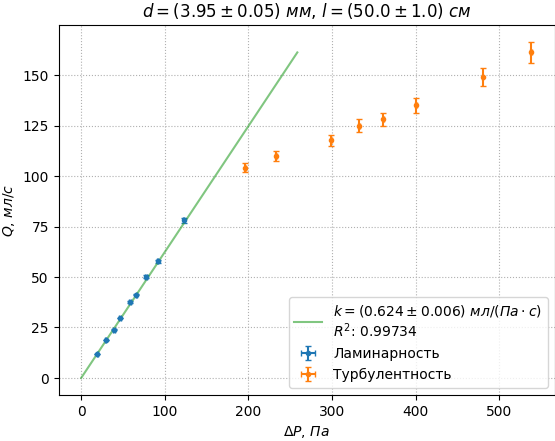

In [16]:
p11(d1, l1, 1)

/var/folders/b0/r7cwq3l97dz61k8mlk7tswlc0000gn/T/ipykernel_8936/3991957768.py:84: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '$\left(2.00 \pm 0.10\right) \times 10^{-5}$' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_table.loc["$\eta, \ Па \cdot с$", column_name] = f'${eta.m:L}$'


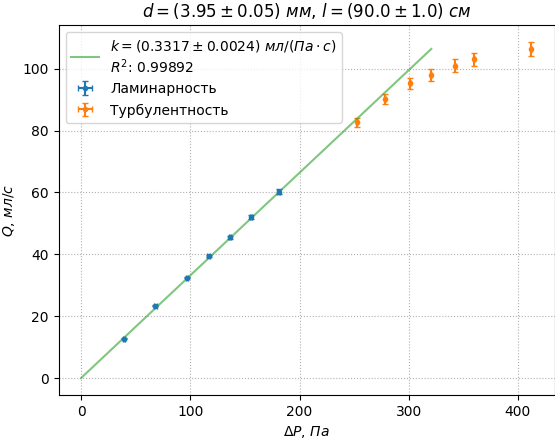

In [17]:
p11(d2, l2, 2)

/var/folders/b0/r7cwq3l97dz61k8mlk7tswlc0000gn/T/ipykernel_8936/3991957768.py:84: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '$\left(2.06 \pm 0.11\right) \times 10^{-5}$' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_table.loc["$\eta, \ Па \cdot с$", column_name] = f'${eta.m:L}$'


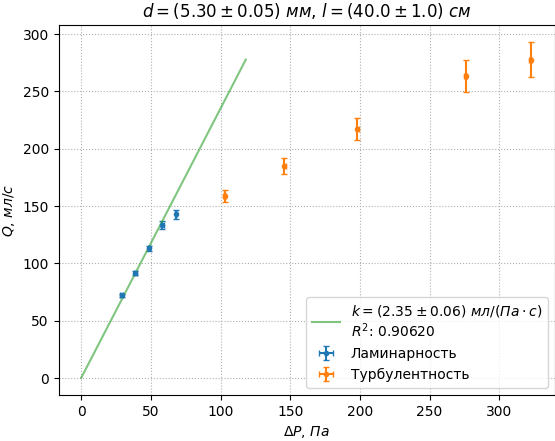

In [18]:
p11(d3, l3, 3)

In [19]:
df_table.to_latex(buf=f"tables/table_processed.tex", index=True, float_format="%.2f", header=False)